In [5]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import Point
#import geoplot as gplt
import seaborn as sns

In [6]:
df = pd.read_csv("finalV1.csv", decimal=",")
df = df.fillna(0)

dfPlanned = pd.read_csv("planned.csv", delimiter=";", decimal=",", error_bad_lines=False)
dfPlanned = dfPlanned.fillna(0)

gdfPlz = gpd.read_file('postleitzahlen.geojson')
gdfPlz = gdfPlz.rename(columns={"postcode":"Postleitzahl"})
gdfBundeslaender = gpd.read_file('bundeslaender.geojson')

/var/folders/n_/bg45v4r938xgcct7rv2bj8gw0000gn/T/ipykernel_61160/3180076899.py:1: DtypeWarning: Columns (20,21,23,24,31,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("finalV1.csv", decimal=",")
/var/folders/n_/bg45v4r938xgcct7rv2bj8gw0000gn/T/ipykernel_61160/3180076899.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfPlanned = pd.read_csv("planned.csv", delimiter=";", decimal=",", error_bad_lines=False)


In [7]:
dfPlanned = dfPlanned.rename(columns={"Koordinate: Längengrad (WGS84)":"Lng", "Koordinate: Breitengrad (WGS84)":"Lat"})

geometry = [Point(xy) for xy in zip(dfPlanned.Lng, dfPlanned.Lat)]
dfPlanned = dfPlanned.drop(['Lng', 'Lat'], axis=1)
gdfPlanned = gpd.GeoDataFrame(dfPlanned, crs="EPSG:4326", geometry=geometry)

In [8]:
df = df.rename(columns={"Koordinate: Längengrad (WGS84)":"Lng", "Koordinate: Breitengrad (WGS84)":"Lat"})

geometry = [Point(xy) for xy in zip(df.Lng, df.Lat)]
df = df.drop(['Lng', 'Lat'], axis=1)
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

In [9]:
gdfPlz.columns

Index(['Postleitzahl', 'locality', 'geometry'], dtype='object')

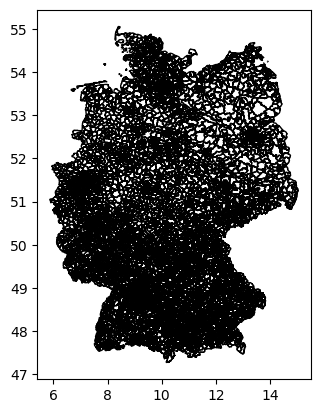

In [10]:
base = gdfPlz.plot(color='white', edgecolor='black')

gdf_merged = gpd.sjoin(gdfPlz, gdf, how='inner')
gdf_merged.head()
counts = gdf_merged.groupby("Postleitzahl_left", dropna=False).count()
counts = counts.rename(columns={"locality": "count"})
counts.head()
gdf_mergedCount = gdf_merged.set_index('Postleitzahl_left').join(counts['count'], how='inner')

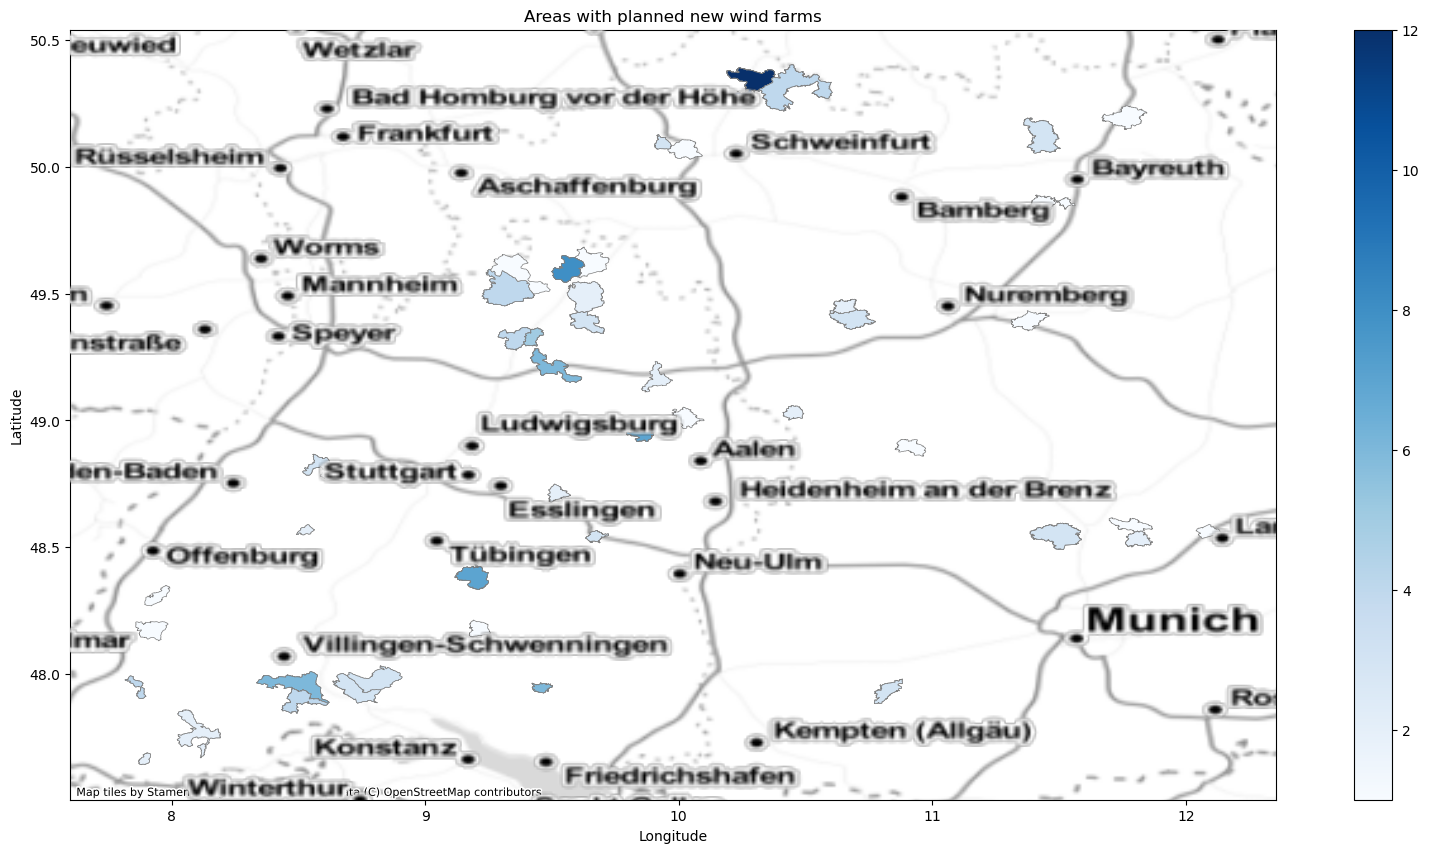

In [11]:
gdf_mergedPlanned = gpd.sjoin(gdfPlz, gdfPlanned, how='inner')
countsPlanned = gdf_mergedPlanned.groupby("Postleitzahl_left", dropna=False).count()
countsPlanned = countsPlanned.rename(columns={"locality": "count"})

gdf_mergedPlanned = gdf_mergedPlanned.set_index('Postleitzahl_left').join(countsPlanned['count'], how='inner')
gdf_mergedPlanned = gdf_mergedPlanned[gdf_mergedPlanned["Energieträger"].isin(["Wind"])]

#ax = gdf_mergedPlanned.plot(marker='*', color="blue", markersize=5, legend=True, figsize=(10,15))
ax = gdf_mergedPlanned.plot(column="count", cmap="Blues", edgecolor='gray', legend=True, linewidth=0.5 ,figsize=(20,10))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Areas with planned new wind farms")

#gdfBundeslaender.plot()

cx.add_basemap(ax, crs=gdf_mergedPlanned.crs, source=cx.providers.Stamen.TonerLite, zoom=7)
cx.add_basemap(ax, crs=gdf_mergedPlanned.crs, source=cx.providers.Stamen.TonerLabels, zoom=7)

plt.savefig('planned-wind.png', format='png', bbox_inches="tight")

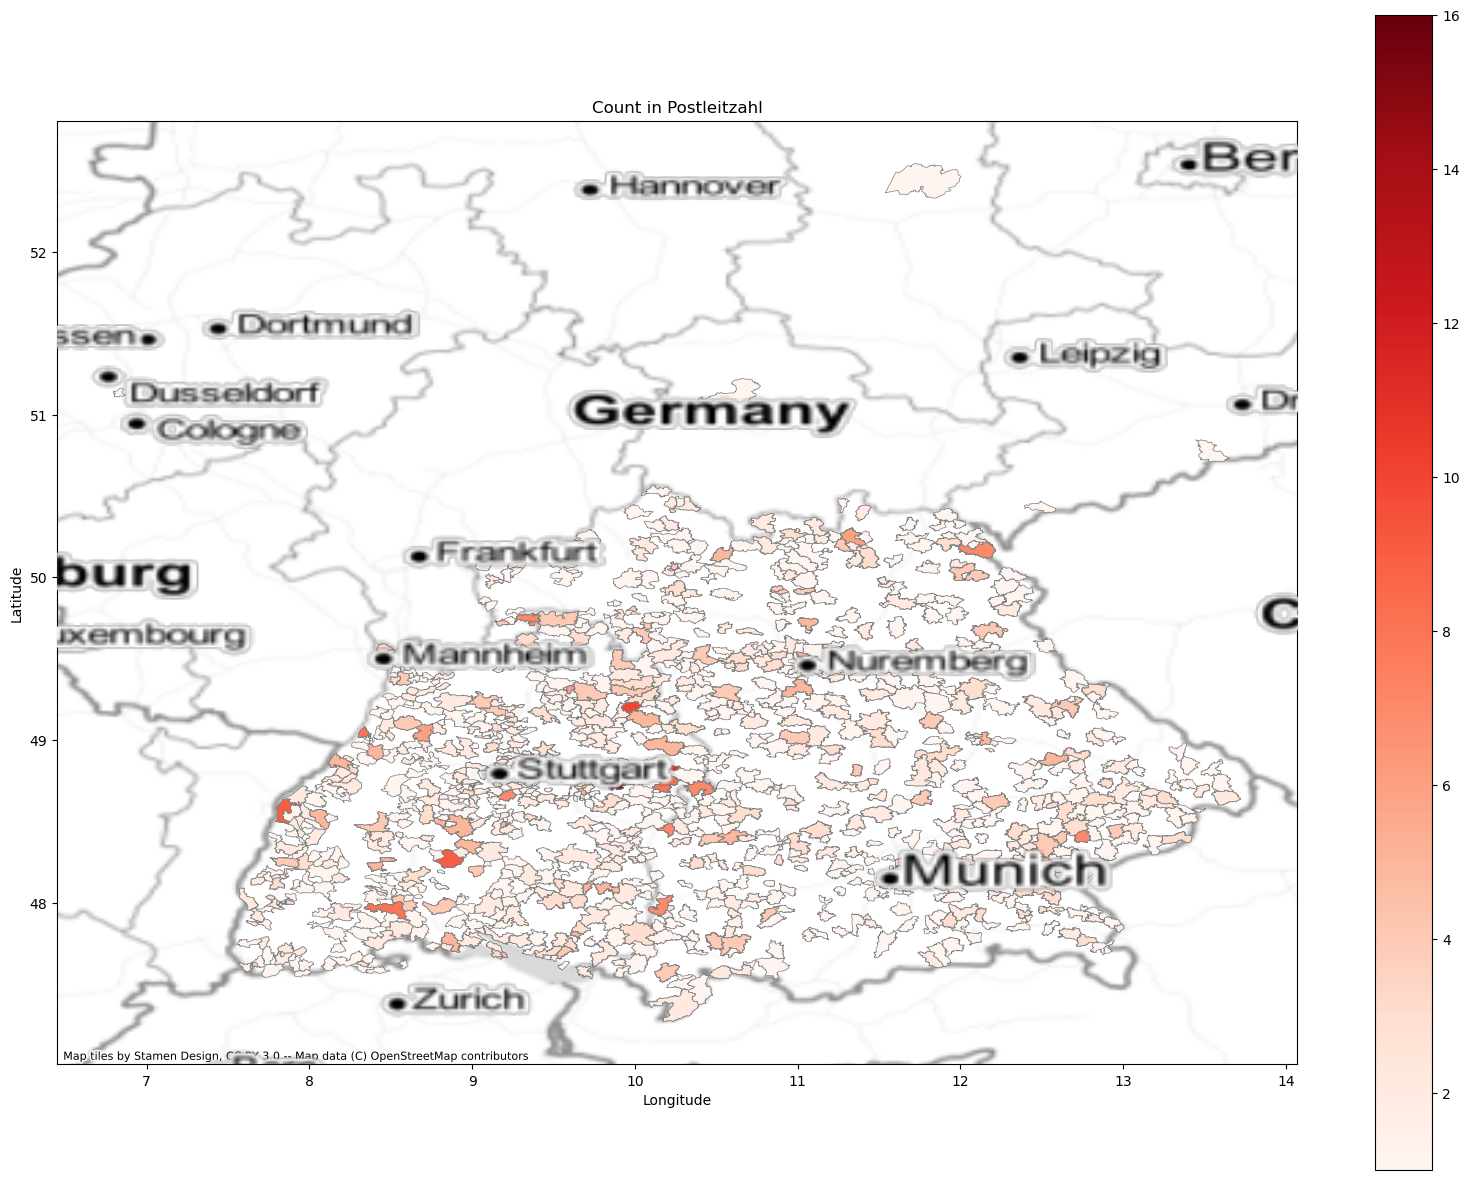

In [12]:
ax = gdf_mergedCount.plot(column="count", cmap="Reds", edgecolor='gray', legend=True, linewidth=0.5 ,figsize=(20,15))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Count in Postleitzahl")

#gdfBundeslaender.plot()

cx.add_basemap(ax, crs=gdf_merged.crs, source=cx.providers.Stamen.TonerLite, zoom=6)
cx.add_basemap(ax, crs=gdf_merged.crs, source=cx.providers.Stamen.TonerLabels, zoom=6)


/var/folders/n_/bg45v4r938xgcct7rv2bj8gw0000gn/T/ipykernel_61160/3678891376.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = gdf_mergedWind.groupby("Postleitzahl_left", dropna=False).sum()


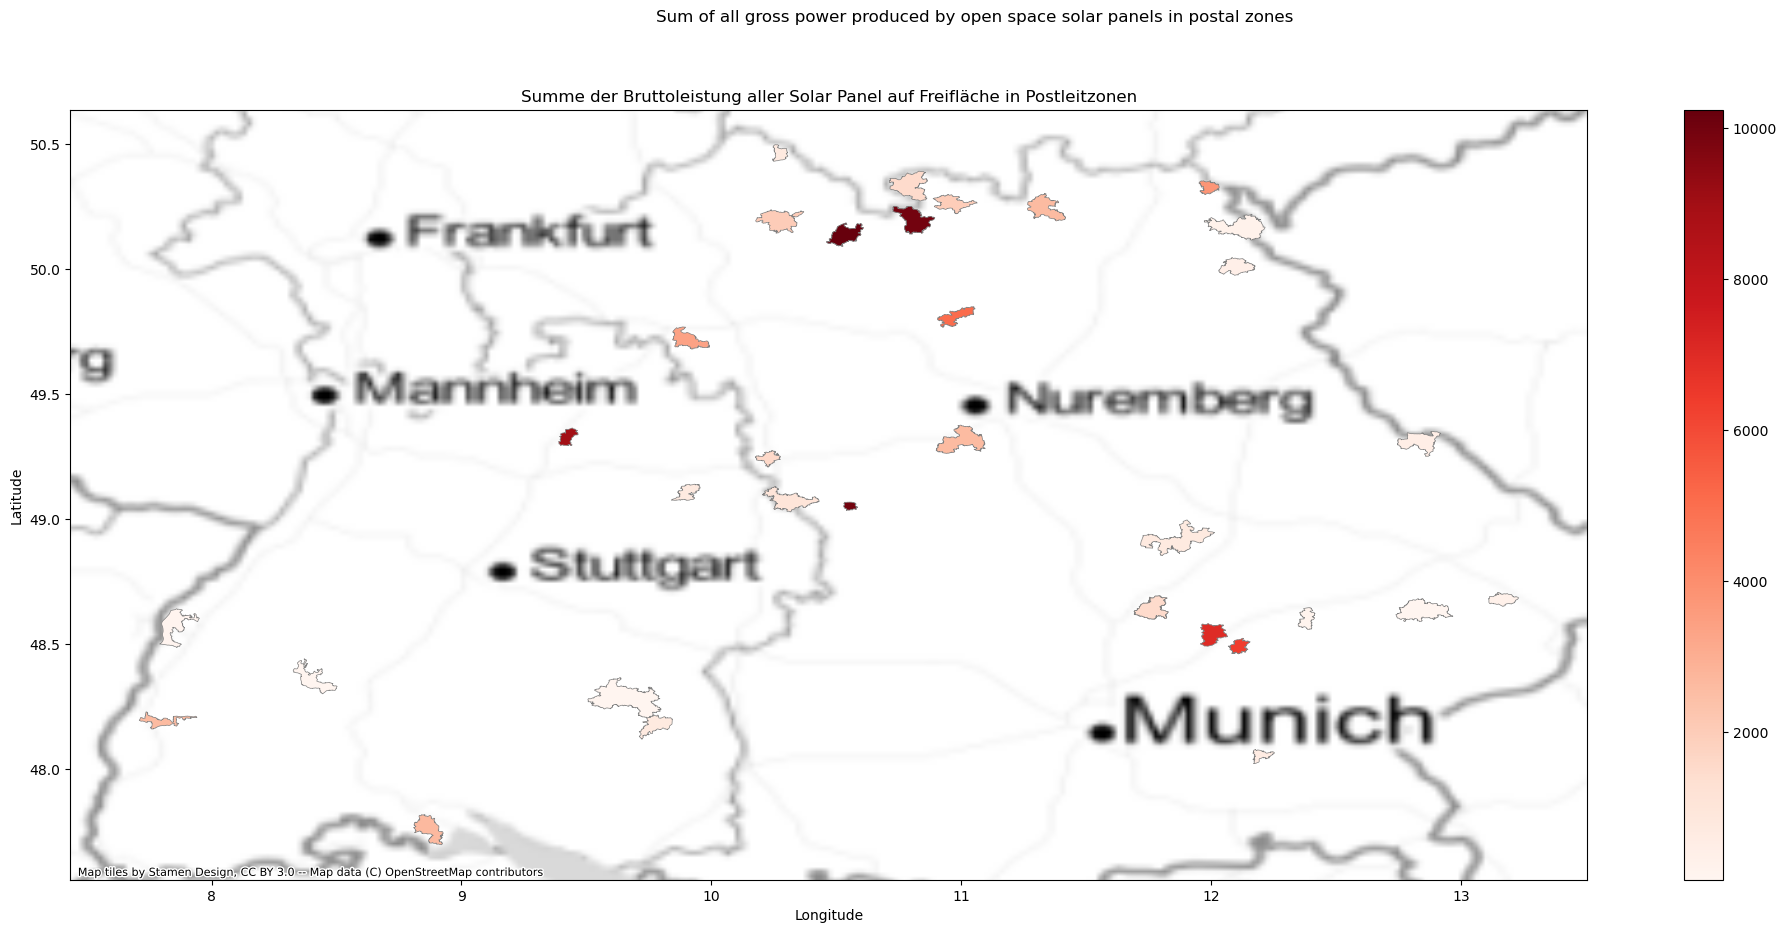

In [21]:
gdf_mergedWind = gdf_merged[gdf_merged["Energieträger"].isin(["Solare Strahlungsenergie", "Solarthermie"])]
gdf_mergedWind = gdf_merged[gdf_merged["Lage der Einheit"].isin(["Freifläche"])]

sums = gdf_mergedWind.groupby("Postleitzahl_left", dropna=False).sum()
sums = sums.rename(columns={"Bruttoleistung der Einheit": "total"})
gdf_mergedSum = gdf_mergedWind.set_index('Postleitzahl_left').join(sums['total'], how='inner')

ax = gdf_mergedSum.plot(column="total", cmap="Reds", edgecolor='gray', legend=True, linewidth=0.5 ,figsize=(25,10))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Summe der Bruttoleistung aller Solar Panel auf Freifläche in Postleitzonen")
plt.suptitle("Sum of all gross power produced by open space solar panels in postal zones")

#gdfBundeslaender.plot()

cx.add_basemap(ax, crs=gdf_merged.crs, source=cx.providers.Stamen.TonerLite, zoom=6)
#cx.add_basemap(ax, crs=gdf_merged.crs, source=cx.providers.Stamen.TonerLabels, zoom=6)

plt.savefig('brutto-sum-solar-freiflaeche.png', format='png', bbox_inches="tight")

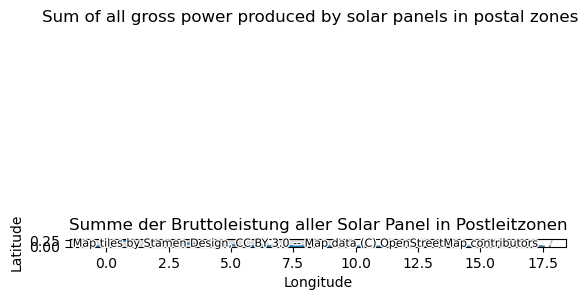

In [19]:
ax = sns.kdeplot(data=gdf_mergedCount['count'])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Summe der Bruttoleistung aller Solar Panel in Postleitzonen")
plt.suptitle("Sum of all gross power produced by solar panels in postal zones")

#gdfBundeslaender.plot()

cx.add_basemap(ax, crs=gdf_merged.crs, source=cx.providers.Stamen.TonerLite, zoom=6)
#cx.add_basemap(ax, crs=gdf_merged.crs, source=cx.providers.Stamen.TonerLabels, zoom=6)

plt.savefig('brutto-sum-solar-clustering.png', format='png', bbox_inches="tight")